LST-LULC Anlysis

In [1]:
import geopandas as gpd
import rasterio
from rasterio import features
from shapely.geometry import Point, shape
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import seaborn as sns

Handelling Raster

In [2]:
# Path to your clipped raster file
raster_file = 'data/lulc.tif'

# Open the raster and read data
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    
    # Get shapes with their values
    mask = raster_data > 0  # Create mask for non-zero values
    shapes = features.shapes(raster_data, mask=mask, transform=transform)
    
    # Convert shapes to GeoDataFrame
    geometries = []
    values = []
    
    for geom, val in shapes:
        geometries.append(shape(geom))
        values.append(val)
    
    # Create GeoDataFrame
    lulc = gpd.GeoDataFrame({
        'geometry': geometries,
        'value': values
    }, crs=src.crs)
    lulc = lulc.to_crs(5243)

# Calculate area for each polygon
    lulc['area'] = lulc.geometry.area / 1_000_000 
    
    # Group by value and sum areas
    area_by_value = lulc.groupby('value')['area'].sum().reset_index()
    print("Area by value:")
    print(area_by_value)

Area by value:
   value       area
0    1.0   2.160081
1    2.0  19.941460
2    7.0  41.891008
3    8.0   0.003359
4   11.0   0.604510



Area by class (km²):
class  class_range
1.0    13.5 - 25.4    12.91
2.0    25.4 - 30.0    12.90
3.0    30.0 - 33.0    12.90
4.0    33.0 - 35.3    12.90
5.0    35.3 - 46.8    12.90
Name: area_km2, dtype: float64


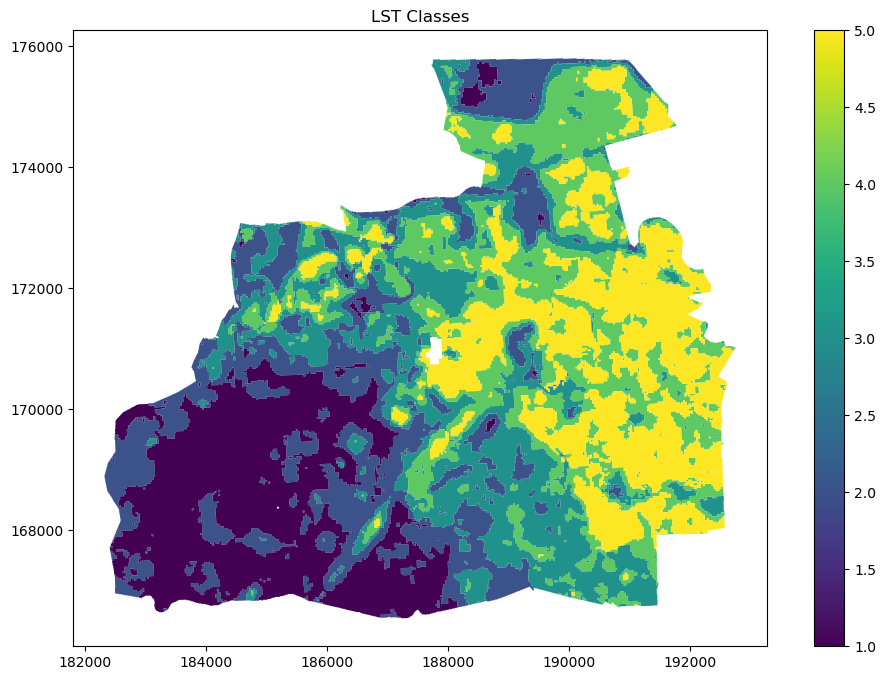

In [3]:
raster_file = 'data/lst.tif'

with rasterio.open(raster_file) as src:
    raster_data = src.read(1).astype('float32')
    transform = src.transform
    
    # Get valid data
    valid_data = raster_data[raster_data > 0]
    
    # Calculate quantile breaks (or use np.linspace for equal interval)
    # Uncomment the desired classification method:
    
    # Quantile breaks:
    breaks = np.percentile(valid_data, [0, 20, 40, 60, 80, 100])
    
    # Equal interval breaks:
    # breaks = np.linspace(valid_data.min(), valid_data.max(), 6)
    
    # Classify the data
    classified_data = np.zeros_like(raster_data)
    for i in range(len(breaks)-1):
        mask = (raster_data > breaks[i]) & (raster_data <= breaks[i+1])
        classified_data[mask] = i + 1
    
    # Vectorize classified data
    shapes = features.shapes(classified_data.astype('int32'), 
                           mask=classified_data > 0, 
                           transform=transform)
    
    geometries = []
    classes = []
    
    for geom, val in shapes:
        geometries.append(shape(geom))
        classes.append(val)
    
    # Create GeoDataFrame
    lst = gpd.GeoDataFrame({
        'geometry': geometries,
        'class': classes,
        'class_range': [f'{breaks[int(c-1)]:.1f} - {breaks[int(c)]:.1f}' for c in classes]
    }, crs=src.crs)
    lst = lst.to_crs(5243)
    # Calculate areas
    lst['area_km2'] = lst.geometry.area / 1_000_000
    
    # Summary statistics
    area_by_class = lst.groupby(['class', 'class_range'])['area_km2'].sum().round(2)
    print("\nArea by class (km²):")
    print(area_by_class)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
lst.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title('LST Classes')
plt.show()

In [4]:
lst.head()

,geometry,class,class_range,area_km2
0,"POLYGON ((187999.318 175775.780, 187999.695 17...",4.0,33.0 - 35.3,0.000608
1,"POLYGON ((189107.969 175787.758, 189108.348 17...",3.0,30.0 - 33.0,0.000547
2,"POLYGON ((188268.202 175755.946, 188269.333 17...",2.0,25.4 - 30.0,0.000912
3,"POLYGON ((189497.804 175792.577, 189498.563 17...",3.0,30.0 - 33.0,0.001156
4,"POLYGON ((190247.430 175791.162, 190247.812 17...",3.0,30.0 - 33.0,0.000183


Using overlay for getting the intersecting features

In [5]:
# Overlay the two layers
intersection = gpd.overlay(lst, lulc, how='intersection')

# Calculate area in km² for each intersection
intersection['area_km2'] = intersection.geometry.area / 1_000_000

In [6]:
intersection.head()

,class,class_range,area_km2,value,area,geometry
0,4.0,33.0 - 35.3,0.000159,7.0,41.423575,"POLYGON ((188060.548 175768.095, 187999.695 17..."
1,3.0,30.0 - 33.0,0.000221,7.0,41.423575,"POLYGON ((189163.115 175779.855, 189108.348 17..."
2,2.0,25.4 - 30.0,0.000912,1.0,0.083495,"POLYGON ((188298.628 175757.096, 188299.760 17..."
3,3.0,30.0 - 33.0,0.000593,7.0,41.423575,"POLYGON ((189559.416 175774.928, 189498.563 17..."
4,3.0,30.0 - 33.0,0.000021,7.0,41.423575,"POLYGON ((190266.067 175781.877, 190247.812 17..."


In [7]:
intersection = intersection.rename(columns={'class_range': 'Temperature'})
# intersection = intersection.set_index('class')


In [8]:
lulc_classes = {
    1: 'Water',
    2: 'Trees',
    4: 'Flooded vegetation',
    5: 'Crops',
    7: 'Built Area',
    8: 'Bare ground',
    9: 'Snow/Ice',
    10: 'Clouds',
    11: 'Rangeland'
}

intersection['Class'] = intersection['value'].map(lulc_classes)
intersection = intersection.sort_index(ascending=True)
intersection.head()

,class,Temperature,area_km2,value,area,geometry,Class
0,4.0,33.0 - 35.3,0.000159,7.0,41.423575,"POLYGON ((188060.548 175768.095, 187999.695 17...",Built Area
1,3.0,30.0 - 33.0,0.000221,7.0,41.423575,"POLYGON ((189163.115 175779.855, 189108.348 17...",Built Area
2,2.0,25.4 - 30.0,0.000912,1.0,0.083495,"POLYGON ((188298.628 175757.096, 188299.760 17...",Water
3,3.0,30.0 - 33.0,0.000593,7.0,41.423575,"POLYGON ((189559.416 175774.928, 189498.563 17...",Built Area
4,3.0,30.0 - 33.0,0.000021,7.0,41.423575,"POLYGON ((190266.067 175781.877, 190247.812 17...",Built Area


In [9]:
intersection['Class'].unique()

array(['Built Area', 'Water', 'Trees', 'Rangeland', 'Bare ground'],
      dtype=object)

In [10]:
# Group by both LULC and temperature classes
area_matrix = intersection.groupby(['class','Temperature','Class'])['area_km2'].sum().reset_index()
area_matrix['area_km2'] = area_matrix['area_km2']
area_matrix

,class,Temperature,Class,area_km2
0,1.0,13.5 - 25.4,Bare ground,0.000094
1,1.0,13.5 - 25.4,Built Area,0.050926
2,1.0,13.5 - 25.4,Rangeland,0.005594
3,1.0,13.5 - 25.4,Trees,12.072019
4,1.0,13.5 - 25.4,Water,0.767380
5,2.0,25.4 - 30.0,Bare ground,0.003265
6,2.0,25.4 - 30.0,Built Area,4.417352
7,2.0,25.4 - 30.0,Rangeland,0.190588
8,2.0,25.4 - 30.0,Trees,6.975302
9,2.0,25.4 - 30.0,Water,1.294414


In [11]:
# Reshape to a pivot table for better visualization
pivot_table = area_matrix.pivot(index='Class', 
                              columns='class', 
                              values='area_km2').round(2)

pivot_table = pivot_table.fillna(0)

In [12]:
print("Area (km²) by Temperature and LULC classes:")
pivot_table = pivot_table.reindex(sorted(pivot_table.columns, reverse=False), axis=1)

print(pivot_table)

Area (km²) by Temperature and LULC classes:
class          1.0   2.0    3.0    4.0    5.0
Class                                        
Bare ground   0.00  0.00   0.00   0.00   0.00
Built Area    0.05  4.42  11.77  12.67  12.84
Rangeland     0.01  0.19   0.20   0.16   0.04
Trees        12.07  6.98   0.84   0.04   0.00
Water         0.77  1.29   0.08   0.01   0.00


In [13]:
pivot_table.columns.name = 'Temperature Class' 

In [14]:
print(pivot_table)

Temperature Class    1.0   2.0    3.0    4.0    5.0
Class                                              
Bare ground         0.00  0.00   0.00   0.00   0.00
Built Area          0.05  4.42  11.77  12.67  12.84
Rangeland           0.01  0.19   0.20   0.16   0.04
Trees              12.07  6.98   0.84   0.04   0.00
Water               0.77  1.29   0.08   0.01   0.00


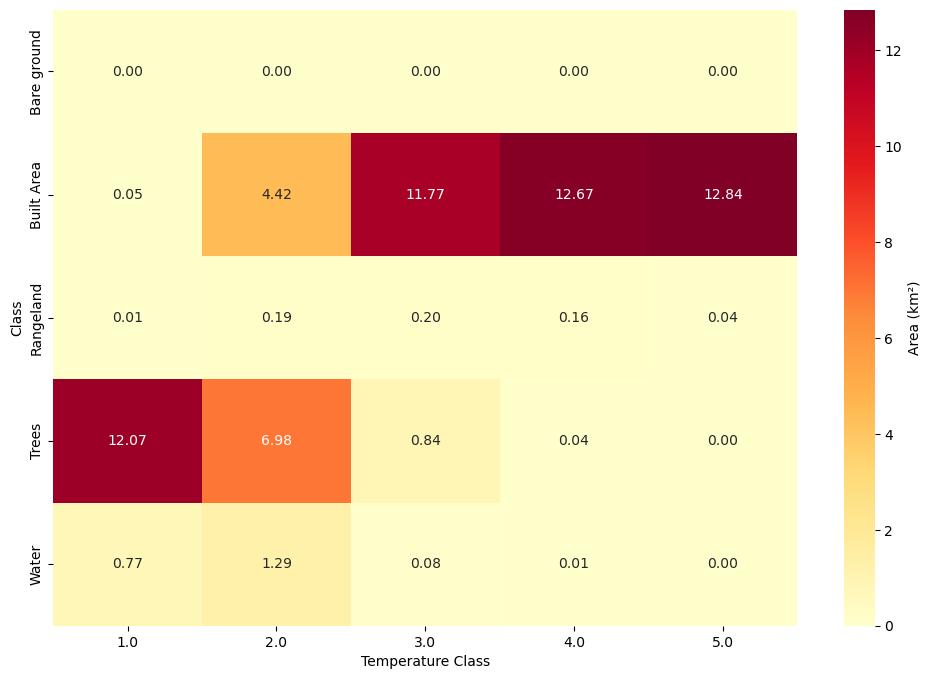

In [15]:
# Create publication-ready table visualization
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, 
            annot=True,  # Show values in cells
            fmt='.2f',   # Two decimal places
            cmap='YlOrRd',
            cbar_kws={'label': 'Area (km²)'},
            )
plt.savefig('output/charlottenburg_lst_lulc.png', dpi=300, bbox_inches='tight')